# 🍳 EDA Universal - Food-101 Desayuno (21 Clases)

**Versión**: 2.0 (actualizado para MobileNetV2)

**Objetivo**: Descargar, limpiar y preprocesar el dataset Food-101 (solo clases de desayuno)

**Salidas**:
- `food101_desayuno_preprocessed.pkl` → Metadata + referencias a NPZ
- `dataset_desayuno_summary.csv` → Resumen legible en CSV
- `c{class}_batch{n}.npz` → Imágenes preprocesadas (224x224x3, uint8, sin normalizar)
- `desayuno_preprocessed_archive.zip` → Todo comprimido para descargar

**Compatible con**: Kaggle, Google Colab, Local (Windows/Mac/Linux)


In [ ]:
# ============================================================================
# CELDA 1: CONFIGURACIÓN AUTOMÁTICA DEL ENTORNO
# ============================================================================

import os
import sys
from pathlib import Path

def detect_environment():
    """Detecta si estamos en Kaggle, Colab o Local"""
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        return 'kaggle'
    elif 'COLAB_GPU' in os.environ or os.path.exists('/content'):
        return 'colab'
    else:
        return 'local'

ENVIRONMENT = detect_environment()
print(f" Entorno detectado: {ENVIRONMENT.upper()}")

if ENVIRONMENT == 'kaggle':
    WORKING_DIR = Path('/kaggle/working')
    INPUT_DIR = Path('/kaggle/input')
elif ENVIRONMENT == 'colab':
    WORKING_DIR = Path('/content')
    INPUT_DIR = Path('/content')
else:
    WORKING_DIR = Path.cwd() / 'data'
    INPUT_DIR = Path.cwd() / 'input'

# Crear solo el directorio de trabajo
WORKING_DIR.mkdir(exist_ok=True, parents=True)

print(f"📂 Directorio de trabajo: {WORKING_DIR}")
print(f"📥 Directorio de entrada: {INPUT_DIR} (solo si kagglehub falla)")
print(f"🎯 Los archivos se guardarán en: {WORKING_DIR / 'desayuno_preprocessed'}")

# Optimización de memoria
import gc
gc.collect()

print("✅ Configuración completada")


🖥️  Entorno detectado: LOCAL
📂 Directorio de trabajo: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/data
📥 Directorio de entrada: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/input (solo si kagglehub falla)
🎯 Los archivos se guardarán en: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/data/desayuno_preprocessed
✅ Configuración completada


In [ ]:
# ============================================================================
# CELDA 2: VERIFICACIÓN E INSTALACIÓN DE DEPENDENCIAS
# ============================================================================

print("Verificando dependencias necesarias...\n")

# Mapeo: módulo de import -> nombre del paquete en pip
required_packages = {
    'kagglehub': 'kagglehub',
    'cv2': 'opencv-python',
    'sklearn': 'scikit-learn',
    'tqdm': 'tqdm',
    'scipy': 'scipy',
    'seaborn': 'seaborn'
}

missing = []

# Verificar cuáles faltan
for module_name, package_name in required_packages.items():
    try:
        __import__(module_name)
        print(f"✅ {package_name}")
    except ImportError:
        print(f"❌ {package_name} - se instalará")
        missing.append(package_name)

# Instalar las que faltan
if missing:
    print(f"\n📥 Instalando {len(missing)} paquete(s): {', '.join(missing)}")
    print("⏳ Esto puede tardar 1-2 minutos...")

    import subprocess
    import sys

    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'install'] + missing,
        capture_output=False,
        text=True
    )

    if result.returncode == 0:
        print(f"\n Paquetes instalados correctamente!")
    else:
        print(f"\n Hubo un error en la instalación")
        raise RuntimeError("Error instalando dependencias")
else:
    print("\n Todas las dependencias ya están instaladas")

print("\n🎉 Listo para continuar!")


📦 Verificando dependencias necesarias...

✅ kagglehub
✅ opencv-python
✅ scikit-learn
✅ tqdm
✅ scipy
✅ seaborn

✅ Todas las dependencias ya están instaladas

🎉 Listo para continuar!


In [ ]:
# ============================================================================
# CELDA 3: IMPORTS Y CONFIGURACIÓN
# ============================================================================

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import cv2
from PIL import Image
import hashlib
import shutil

warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("✅ Imports completados")

✅ Imports completados


In [ ]:
# ============================================================================
# CELDA 4: DESCARGA DEL DATASET FOOD-101
# ============================================================================

print("\n[PASO 1] Descargando dataset Food-101 desde Kaggle...")
print("-" * 80)

import kagglehub

DESAYUNO_CLASSES = [
    'apple_pie', 'beignets', 'bread_pudding', 'breakfast_burrito',
    'cannoli', 'carrot_cake', 'cheesecake', 'chocolate_cake', 'churros',
    'club_sandwich', 'croque_madame', 'cup_cakes', 'donuts', 'eggs_benedict',
    'french_toast', 'grilled_cheese_sandwich', 'huevos_rancheros', 'omelette',
    'pancakes', 'strawberry_shortcake', 'waffles'
]

print(f" Clases de desayuno objetivo: {len(DESAYUNO_CLASSES)}")

try:
    # MÉTODO PRINCIPAL: Descargar usando kagglehub (descarga automática + caché)
    dataset_path = kagglehub.dataset_download("kmader/food41")
    print(f"✅ Dataset descargado en: {dataset_path}")
    DATASET_DIR = Path(dataset_path)
except Exception as e:
    print(f"⚠️  Error al descargar: {e}")
    print("💡 Intentando con ruta local (fallback)...")

    if ENVIRONMENT == 'local':
        INPUT_DIR.mkdir(exist_ok=True, parents=True)

        local_path = INPUT_DIR / "food41"
        if local_path.exists():
            DATASET_DIR = local_path
            print(f" Usando dataset local: {DATASET_DIR}")
        else:
            print("\n Dataset no encontrado.")
            print(f"Opciones:")
            print(f"   1. Configura credenciales de Kaggle (~/.kaggle/kaggle.json)")
            print(f"   2. O descarga manualmente en: {local_path}")
            raise FileNotFoundError(f"Dataset no encontrado en {local_path}")
    else:
        raise

# Verificar estructura
images_path = DATASET_DIR / "images"
if not images_path.exists():
    images_path = DATASET_DIR

print(f"Ruta de imágenes: {images_path}")
print(f"Dataset listo para procesar")



[PASO 1] Descargando dataset Food-101 desde Kaggle...
--------------------------------------------------------------------------------
🍳 Clases de desayuno objetivo: 21
✅ Dataset descargado en: /Users/cristian/.cache/kagglehub/datasets/kmader/food41/versions/5
📂 Ruta de imágenes: /Users/cristian/.cache/kagglehub/datasets/kmader/food41/versions/5/images
✅ Dataset listo para procesar


In [ ]:
# ============================================================================
# CELDA 5: EXPLORACIÓN INICIAL Y CONTEO
# ============================================================================

print("\n[PASO 2] Explorando dataset y filtrando clases de desayuno...")
print("-" * 80)

# Listar todas las clases disponibles
all_classes = sorted([
    d.name for d in images_path.iterdir()
    if d.is_dir()
])

print(f"📊 Total de clases en Food-101: {len(all_classes)}")

# Filtrar solo las clases de desayuno
classes = [c for c in all_classes if c in DESAYUNO_CLASSES]
missing_classes = set(DESAYUNO_CLASSES) - set(classes)

print(f" Clases de desayuno encontradas: {len(classes)}")
if missing_classes:
    print(f" Clases no encontradas: {missing_classes}")

# Contar imágenes por clase
images_per_class = {}
total_images = 0

print("\n Contando imágenes por clase...")
for class_name in tqdm(classes, desc="Clases"):
    class_path = images_path / class_name
    num_images = len(list(class_path.glob('*.jpg')))
    images_per_class[class_name] = num_images
    total_images += num_images

print(f"\n Total de imágenes de desayuno: {total_images:,}")
print(f"   Min por clase: {min(images_per_class.values())}")
print(f"   Max por clase: {max(images_per_class.values())}")
print(f"   Media por clase: {np.mean(list(images_per_class.values())):.1f}")


[PASO 2] Explorando dataset y filtrando clases de desayuno...
--------------------------------------------------------------------------------
📊 Total de clases en Food-101: 101
✅ Clases de desayuno encontradas: 21

📈 Contando imágenes por clase...


Clases: 100%|██████████| 21/21 [00:00<00:00, 162.90it/s]


✅ Total de imágenes de desayuno: 21,000
   Min por clase: 1000
   Max por clase: 1000
   Media por clase: 1000.0


In [ ]:
# ============================================================================
# CELDA 6: DETECCIÓN Y ELIMINACIÓN DE DUPLICADOS
# ============================================================================

print("\n[PASO 3] Detectando y eliminando imágenes duplicadas...")
print("-" * 80)

def calculate_dhash(img_path, hash_size=8):
    """Calcula perceptual hash (dhash) de una imagen"""
    try:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None

        # Redimensionar a hash_size+1 x hash_size
        img = cv2.resize(img, (hash_size + 1, hash_size))

        # Calcular diferencias horizontales
        diff = img[:, 1:] > img[:, :-1]

        # Convertir a string binario
        return ''.join('1' if pixel else '0' for row in diff for pixel in row)
    except Exception:
        return None

# Crear directorio de trabajo limpio
images_clean_path = WORKING_DIR / 'images_clean'
if images_clean_path.exists():
    shutil.rmtree(images_clean_path)
images_clean_path.mkdir(exist_ok=True)

total_scanned = 0
total_duplicates = 0
duplicates_list = {}

print("Analizando duplicados...")

for class_name in tqdm(classes, desc="Procesando clases"):
    src_class_path = images_path / class_name
    dst_class_path = images_clean_path / class_name
    dst_class_path.mkdir(exist_ok=True)

    images = sorted(src_class_path.glob('*.jpg'))
    hashes = {}
    duplicates = []

    for img_path in images:
        dhash = calculate_dhash(img_path)
        total_scanned += 1

        if dhash is None:
            continue

        if dhash in hashes:
            duplicates.append(img_path.name)
            total_duplicates += 1
        else:
            hashes[dhash] = img_path.name
            shutil.copy(img_path, dst_class_path / img_path.name)

    duplicates_list[class_name] = duplicates

print(f"\n Análisis completado:")
print(f"   Total escaneadas: {total_scanned:,}")
print(f"   Duplicados encontrados: {total_duplicates:,} ({100*total_duplicates/total_scanned:.1f}%)")
print(f"   Imágenes únicas: {total_scanned - total_duplicates:,}")


[PASO 3] Detectando y eliminando imágenes duplicadas...
--------------------------------------------------------------------------------
🔍 Analizando duplicados...


Procesando clases: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


✅ Análisis completado:
   Total escaneadas: 21,000
   Duplicados encontrados: 12 (0.1%)
   Imágenes únicas: 20,988


In [ ]:
# ============================================================================
# CELDA 7: ANÁLISIS DE CALIDAD DE IMÁGENES
# ============================================================================

print("\n[PASO 4] Analizando calidad de imágenes...")
print("-" * 80)

class ImageQualityChecker:
    """Detector de imágenes problemáticas (rostros, manos, borrosas)"""

    @staticmethod
    def detect_human_skin(img_array):
        """Detecta porcentaje de piel humana en la imagen"""
        r = img_array[:, :, 0].astype(float)
        g = img_array[:, :, 1].astype(float)
        b = img_array[:, :, 2].astype(float)

        rgb_cond = ((r > 95) & (r < 255) & (g > 40) & (g < 220) &
                    (b > 20) & (b < 200) & (r > g) & (g > b))

        diff_rg = r - g
        diff_rb = r - b
        diff_cond = (diff_rg > 15) & (diff_rb > 15) & (diff_rg < 80)

        skin_mask = rgb_cond & diff_cond
        skin_percentage = 100 * np.count_nonzero(skin_mask) / skin_mask.size

        return skin_percentage

    @staticmethod
    def check_sharpness(img_array):
        """Verifica si la imagen es nítida"""
        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        sharpness = laplacian.var()
        return sharpness > 50

    @staticmethod
    def analyze_image(img_path):
        """Análisis completo de una imagen"""
        try:
            img = cv2.imread(str(img_path))
            if img is None:
                return {'is_valid': False, 'reason': 'Error lectura'}

            skin_pct = ImageQualityChecker.detect_human_skin(img)
            is_sharp = ImageQualityChecker.check_sharpness(img)

            has_too_much_skin = skin_pct > 40
            is_blurry = not is_sharp

            is_problematic = has_too_much_skin or (is_blurry and skin_pct > 30)

            return {
                'is_valid': not is_problematic,
                'skin_percentage': skin_pct,
                'is_sharp': is_sharp,
                'is_problematic': is_problematic,
                'reason': 'OK' if not is_problematic else 'Rostro/Manos o Borrosa'
            }
        except Exception as e:
            return {'is_valid': False, 'reason': str(e)}

checker = ImageQualityChecker()
quality_results = []
sample_per_class = 20

print(f" Analizando {sample_per_class} imágenes por clase...")

for class_name in tqdm(classes, desc="Análisis de calidad"):
    class_path = images_clean_path / class_name
    images = sorted(class_path.glob('*.jpg'))[:sample_per_class]

    for img_path in images:
        result = checker.analyze_image(img_path)
        result['class'] = class_name
        result['filename'] = img_path.name
        quality_results.append(result)

df_quality = pd.DataFrame(quality_results)

print(f"\n Imágenes analizadas: {len(df_quality)}")
if len(df_quality) > 0:
    problematic = df_quality['is_problematic'].sum()
    print(f"   Problemáticas detectadas: {problematic} ({100*problematic/len(df_quality):.1f}%)")
    print(f"   Porcentaje piel promedio: {df_quality['skin_percentage'].mean():.1f}%")
    print(f"   Imágenes nítidas: {df_quality['is_sharp'].sum()} ({100*df_quality['is_sharp'].sum()/len(df_quality):.1f}%)")


[PASO 4] Analizando calidad de imágenes...
--------------------------------------------------------------------------------
🔎 Analizando 20 imágenes por clase...


Análisis de calidad: 100%|██████████| 21/21 [00:02<00:00,  9.84it/s]


✅ Imágenes analizadas: 420
   Problemáticas detectadas: 1 (0.2%)
   Porcentaje piel promedio: 2.7%
   Imágenes nítidas: 409 (97.4%)


In [ ]:
# ============================================================================
# CELDA 8: PREPROCESAMIENTO Y GENERACIÓN DE NPZ
# ============================================================================

print("\n[PASO 5] Preprocesando imágenes y generando archivos NPZ...")
print("-" * 80)

TARGET_SIZE = 224
BATCH_SIZE = 20
SAVE_DIR = WORKING_DIR / 'desayuno_preprocessed'
NPZ_DIR = SAVE_DIR / 'npz_files'
SAVE_DIR.mkdir(exist_ok=True)
NPZ_DIR.mkdir(exist_ok=True)

stats = {}
total_processed = 0
total_skipped = 0
npz_files_created = []

print(f" Tamaño objetivo: {TARGET_SIZE}x{TARGET_SIZE}x3 (Compatible con MobileNetV2)")
print(f" Batch size: {BATCH_SIZE} imágenes/archivo")
print(f" NPZ se guardarán en: {NPZ_DIR.relative_to(WORKING_DIR)}")

for class_idx, class_name in enumerate(tqdm(classes, desc="Procesando clases")):
    class_path = images_clean_path / class_name

    if not class_path.exists():
        stats[class_name] = {'processed': 0, 'skipped': 0}
        continue

    images = sorted(class_path.glob('*.jpg'))

    # Filtrar imágenes problemáticas (solo las analizadas)
    problem_images = set(
        df_quality[
            (df_quality['class'] == class_name) &
            (df_quality['is_problematic'])
        ]['filename']
    ) if len(df_quality) > 0 else set()

    X_buffer = []
    y_buffer = []
    processed = 0
    skipped = 0
    batch_num = 0

    for img_path in images:
        if img_path.name in problem_images:
            skipped += 1
            continue

        try:
            img = cv2.imread(str(img_path))
            if img is None:
                skipped += 1
                continue

            img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE),
                           interpolation=cv2.INTER_LANCZOS4)

            img_array = img.astype(np.uint8)

            X_buffer.append(img_array)
            y_buffer.append(class_idx)
            processed += 1

            # Guardar batch cuando alcanza el tamaño
            if len(X_buffer) >= BATCH_SIZE:
                npz_filename = f'c{class_idx:03d}_batch{batch_num:04d}.npz'
                npz_path = NPZ_DIR / npz_filename

                np.savez_compressed(
                    npz_path,
                    X=np.array(X_buffer, dtype=np.uint8),
                    y=np.array(y_buffer, dtype=np.int16)
                )

                npz_files_created.append(f'npz_files/{npz_filename}')
                X_buffer.clear()
                y_buffer.clear()
                batch_num += 1

        except Exception as e:
            skipped += 1
            continue

    # Guardar imágenes restantes
    if X_buffer:
        npz_filename = f'c{class_idx:03d}_batch{batch_num:04d}.npz'
        npz_path = NPZ_DIR / npz_filename

        np.savez_compressed(
            npz_path,
            X=np.array(X_buffer, dtype=np.uint8),
            y=np.array(y_buffer, dtype=np.int16)
        )

        npz_files_created.append(f'npz_files/{npz_filename}')

    stats[class_name] = {'processed': processed, 'skipped': skipped}
    total_processed += processed
    total_skipped += skipped

print(f"\n Preprocesamiento completado:")
print(f"   Imágenes procesadas: {total_processed:,}")
print(f"   Imágenes saltadas: {total_skipped:,}")
print(f"   Archivos NPZ generados: {len(npz_files_created)}")
print(f"   Tamaño de imágenes: {TARGET_SIZE}x{TARGET_SIZE}x3")

np.save(SAVE_DIR / 'stats.npy', stats)



[PASO 5] Preprocesando imágenes y generando archivos NPZ...
--------------------------------------------------------------------------------
📐 Tamaño objetivo: 224x224x3 (Compatible con MobileNetV2)
📦 Batch size: 20 imágenes/archivo
📁 NPZ se guardarán en: desayuno_preprocessed/npz_files


Procesando clases: 100%|██████████| 21/21 [02:02<00:00,  5.84s/it]


✅ Preprocesamiento completado:
   Imágenes procesadas: 20,987
   Imágenes saltadas: 1
   Archivos NPZ generados: 1050
   Tamaño de imágenes: 224x224x3


In [ ]:
# ============================================================================
# CELDA 9: GUARDAR PICKLE Y CSV
# ============================================================================

print("\n[PASO 6] Guardando metadata del dataset...")
print("-" * 80)

# Calcular distribución final
distribucion_clases = {cls: stats[cls]['processed'] for cls in classes}

final_stats = {
    'total_clases': len(classes),
    'total_imagenes': total_processed,
    'imagenes_duplicadas': total_duplicates,
    'imagenes_problematicas': total_skipped,
    'distribucion_clases': distribucion_clases,
    'target_size': TARGET_SIZE,
    'dtype': 'uint8',
    'normalized': False,
    'range': '[0, 255]',
    'compatible_with': 'MobileNetV2',
    'version': '2.0'
}

# ============================
# 1. GUARDAR PICKLE (PRINCIPAL)
# ============================
dataset_package = {
    'npz_files': npz_files_created,
    'class_names': classes,
    'stats': final_stats
}

PKL_OUTPUT = SAVE_DIR / 'food101_desayuno_preprocessed.pkl'
with open(PKL_OUTPUT, 'wb') as f:
    pickle.dump(dataset_package, f)

print(f" Pickle guardado: {PKL_OUTPUT}")
print(f"   Tamaño: {PKL_OUTPUT.stat().st_size / 1024:.2f} KB")
print(f"   Versión: {final_stats['version']}")
print(f"   Compatible con: {final_stats['compatible_with']}")

# ============================
# 2. GUARDAR CSV (RESUMEN LEGIBLE)
# ============================
summary_df = pd.DataFrame({
    'clase_nombre': classes,
    'num_imagenes': [distribucion_clases[cls] for cls in classes],
    'porcentaje': [100 * distribucion_clases[cls] / total_processed for cls in classes]
})

CSV_OUTPUT = SAVE_DIR / 'dataset_desayuno_summary.csv'
summary_df.to_csv(CSV_OUTPUT, index=False)

print(f" CSV guardado: {CSV_OUTPUT}")
print(f"\n📊 Resumen:")
print(summary_df.to_string(index=False))

# ============================
# 3. GUARDAR CÓDIGO DE EJEMPLO ACTUALIZADO
# ============================
load_example = """
# ============================================================================
# CÓDIGO PARA CARGAR EL DATASET PREPROCESADO (v2.0)
# ============================================================================

import pickle
import numpy as np
from pathlib import Path

# Ruta al archivo pickle (relativa desde notebooks/)
PKL_PATH = 'data/desayuno_preprocessed/food101_desayuno_preprocessed.pkl'

# Cargar metadata
with open(PKL_PATH, 'rb') as f:
    data = pickle.load(f)

npz_files = data['npz_files']
class_names = data['class_names']
stats = data['stats']

print(f"Clases: {len(class_names)}")
print(f"Imágenes totales: {stats['total_imagenes']:,}")
print(f"Archivos NPZ: {len(npz_files)}")
print(f"Tamaño de imágenes: {stats['target_size']}x{stats['target_size']}")
print(f"Tipo de dato: {stats['dtype']}")
print(f"Rango: {stats['range']}")

# Cargar todas las imágenes (requiere RAM ~4GB)
X_list = []
y_list = []

base_path = Path('data/desayuno_preprocessed')
for npz_file in npz_files:
    # Extraer solo el nombre del archivo
    npz_filename = Path(npz_file).name
    npz_path = base_path / 'npz_files' / npz_filename

    with np.load(npz_path) as npz:
        X_list.append(npz['X'])
        y_list.append(npz['y'])

X = np.concatenate(X_list, axis=0)  # (N, 224, 224, 3) uint8
y = np.concatenate(y_list, axis=0)  # (N,) int16

print(f"\\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X dtype: {X.dtype}")
print(f"Rango X: [{X.min()}, {X.max()}]")

# Normalizar si es necesario (para entrenamiento)
X_normalized = X.astype('float32') / 255.0
print(f"\\nX normalizado: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

# ============================================================================
# ALTERNATIVA: CARGAR POR LOTES (MEMORY-EFFICIENT)
# ============================================================================

def load_batch_generator(npz_files, base_path='data/desayuno_preprocessed'):
    '''Generador que carga imágenes por lotes'''
    base = Path(base_path)
    for npz_file in npz_files:
        npz_filename = Path(npz_file).name
        npz_path = base / 'npz_files' / npz_filename
        with np.load(npz_path) as npz:
            X_batch = npz['X'].astype('float32') / 255.0  # Normalizar
            y_batch = npz['y']
            yield X_batch, y_batch

# Uso:
gen = load_batch_generator(npz_files)
X_batch, y_batch = next(gen)
print(f"\\nBatch shape: {X_batch.shape}")
print(f"Batch dtype: {X_batch.dtype}")
"""

EXAMPLE_OUTPUT = SAVE_DIR / 'load_dataset_example.py'
with open(EXAMPLE_OUTPUT, 'w') as f:
    f.write(load_example)

print(f" Ejemplo de código guardado: {EXAMPLE_OUTPUT}")



[PASO 6] Guardando metadata del dataset...
--------------------------------------------------------------------------------
✅ Pickle guardado: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/data/desayuno_preprocessed/food101_desayuno_preprocessed.pkl
   Tamaño: 32.54 KB
   Versión: 2.0
   Compatible con: MobileNetV2
✅ CSV guardado: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/data/desayuno_preprocessed/dataset_desayuno_summary.csv

📊 Resumen:
           clase_nombre  num_imagenes  porcentaje
              apple_pie           999    4.760090
               beignets           999    4.760090
          bread_pudding          1000    4.764854
      breakfast_burrito           998    4.755325
                cannoli           999    4.760090
            carrot_cake          1000    4.764854
             cheesecake          1000    4.764854
         chocolate_cake           998    4.755325
                churros           999    4.760090
          club_sandwich 


[PASO 7] Generando visualizaciones...
--------------------------------------------------------------------------------


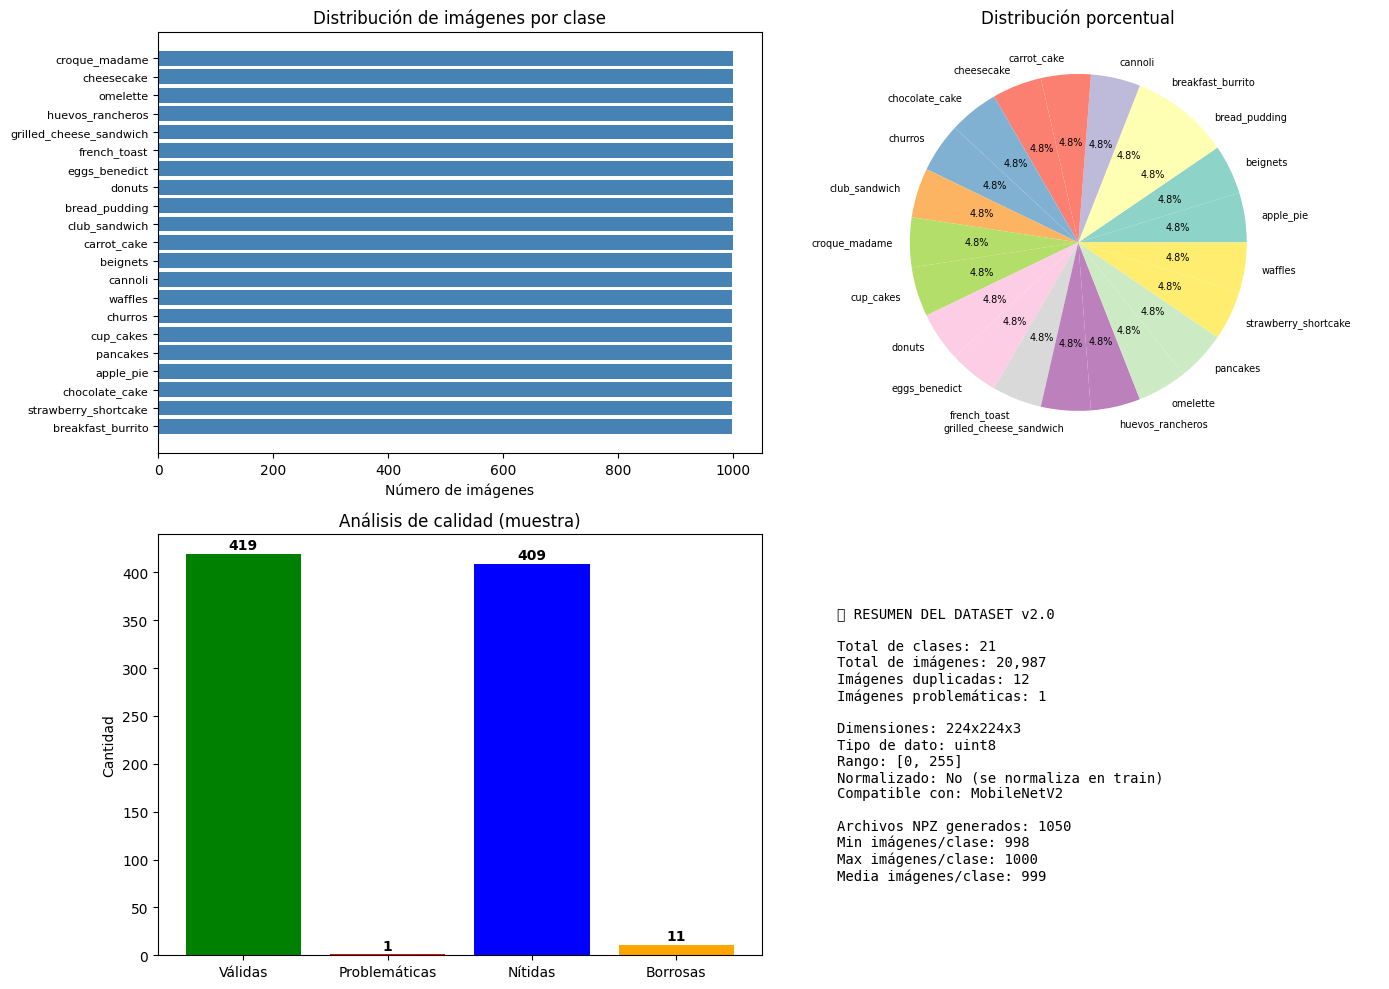

✅ Visualizaciones generadas y guardadas


In [ ]:
# ============================================================================
# CELDA 10: VISUALIZACIONES
# ============================================================================

print("\n[PASO 7] Generando visualizaciones...")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de imágenes por clase
ax1 = axes[0, 0]
summary_sorted = summary_df.sort_values('num_imagenes', ascending=True)
ax1.barh(summary_sorted['clase_nombre'], summary_sorted['num_imagenes'], color='steelblue')
ax1.set_xlabel('Número de imágenes')
ax1.set_title('Distribución de imágenes por clase')
ax1.tick_params(axis='y', labelsize=8)

# 2. Distribución porcentual
ax2 = axes[0, 1]
colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))
ax2.pie(summary_df['num_imagenes'], labels=summary_df['clase_nombre'], autopct='%1.1f%%',
        colors=colors, textprops={'fontsize': 7})
ax2.set_title('Distribución porcentual')

# 3. Estadísticas de calidad
ax3 = axes[1, 0]
if len(df_quality) > 0:
    quality_stats = [
        ('Válidas', (~df_quality['is_problematic']).sum()),
        ('Problemáticas', df_quality['is_problematic'].sum()),
        ('Nítidas', df_quality['is_sharp'].sum()),
        ('Borrosas', (~df_quality['is_sharp']).sum())
    ]
    labels, values = zip(*quality_stats)
    ax3.bar(labels, values, color=['green', 'red', 'blue', 'orange'])
    ax3.set_ylabel('Cantidad')
    ax3.set_title('Análisis de calidad (muestra)')
    for i, v in enumerate(values):
        ax3.text(i, v + 5, str(v), ha='center', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'No hay datos de calidad', ha='center', va='center')
    ax3.set_title('Análisis de calidad')

# 4. Resumen numérico
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
📊 RESUMEN DEL DATASET v2.0

Total de clases: {final_stats['total_clases']}
Total de imágenes: {final_stats['total_imagenes']:,}
Imágenes duplicadas: {final_stats['imagenes_duplicadas']:,}
Imágenes problemáticas: {final_stats['imagenes_problematicas']:,}

Dimensiones: {TARGET_SIZE}x{TARGET_SIZE}x3
Tipo de dato: {final_stats['dtype']}
Rango: {final_stats['range']}
Normalizado: No (se normaliza en train)
Compatible con: {final_stats['compatible_with']}

Archivos NPZ generados: {len(npz_files_created)}
Min imágenes/clase: {min(distribucion_clases.values())}
Max imágenes/clase: {max(distribucion_clases.values())}
Media imágenes/clase: {np.mean(list(distribucion_clases.values())):.0f}
"""
ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
         verticalalignment='center')

plt.tight_layout()
plt.savefig(SAVE_DIR / 'dataset_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualizaciones generadas y guardadas")


In [ ]:
# ============================================================================
# CELDA 11: COMPRIMIR Y DESCARGAR (OPCIONAL)
# ============================================================================

print("\n[PASO 8] Comprimiendo dataset para descarga...")
print("-" * 80)

import zipfile

ZIP_OUTPUT = WORKING_DIR / 'desayuno_preprocessed_archive.zip'

# Crear ZIP con todos los archivos
with zipfile.ZipFile(ZIP_OUTPUT, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_path in SAVE_DIR.rglob('*'):
        if file_path.is_file():
            arcname = file_path.relative_to(SAVE_DIR.parent)
            zipf.write(file_path, arcname)

zip_size_mb = ZIP_OUTPUT.stat().st_size / (1024**2)
print(f"✅ ZIP creado: {ZIP_OUTPUT}")
print(f"   Tamaño: {zip_size_mb:.2f} MB")

# descargar automáticamente (solo en Colab)
if ENVIRONMENT == 'colab':
    try:
        from google.colab import files
        files.download(str(ZIP_OUTPUT))
        print(" Descarga iniciada automáticamente")
    except Exception as e:
        print(f" No se pudo iniciar descarga automática: {e}")
        print(f" Descarga manualmente desde: {ZIP_OUTPUT}")
elif ENVIRONMENT == 'kaggle':
    print(" En Kaggle, el archivo está disponible en el output del kernel")
else:
    print(f" Archivo disponible en: {ZIP_OUTPUT}")


[PASO 8] Comprimiendo dataset para descarga...
--------------------------------------------------------------------------------
✅ ZIP creado: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/data/desayuno_preprocessed_archive.zip
   Tamaño: 2533.37 MB
💡 Archivo disponible en: /Users/cristian/Desktop/proyecto7_ensemble_grupo2/notebooks/data/desayuno_preprocessed_archive.zip


## ✅ EDA COMPLETADO

### 📦 Archivos Generados:

1. **`food101_desayuno_preprocessed.pkl`** (PRINCIPAL)
   - Metadata del dataset (versión 2.0)
   - Lista de archivos NPZ
   - Estadísticas completas

2. **`dataset_desayuno_summary.csv`** (RESUMEN)
   - Tabla legible con conteos por clase
   - Formato CSV para Excel/Google Sheets

3. **`c{class}_batch{n}.npz`** (IMÁGENES - v2.0)
   - Arrays NumPy comprimidos
   - Formato: (batch_size, 224, 224, 3) **uint8**
   - Rango: [0, 255] (sin normalizar)
   - Compatible con MobileNetV2

4. **`load_dataset_example.py`** (CÓDIGO DE EJEMPLO)
   - Código Python para cargar el dataset
   - Incluye normalización para entrenamiento
   - Generador por lotes (memory-efficient)

5. **`dataset_summary.png`**
   - Visualizaciones del dataset
   - Distribución por clase
   - Estadísticas de calidad

### ? Cambios en v2.0:
- ✅ Imágenes 224x224 (antes 48x48)
- ✅ Formato uint8 (antes float16)
- ✅ Sin normalización en dataset (se normaliza en train)
- ✅ Compatible con MobileNetV2 nativo
- ✅ Mejor calidad de imagen (sin upscaling)
